In [56]:
import os # conda activate cs412projEnv
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt

DATASET_PATH = './dataset/20000/'
NUM_EPOCHS = 30
SEED = 23
NUM_SAMPLES_20000 = True

DEBUG = True
def debug_print(message):
    if DEBUG:
        print(message)

synthetic_data_files = os.listdir(DATASET_PATH)

In [57]:
# Filter out the data files from the list of extracted files
# discard images and .eps files
data_files = [file for file in synthetic_data_files if file.startswith('A')]

# separate the files based on the number of time steps (500 or 20000)
data_files_500 = [file for file in data_files if '000500s' in file]
data_files_20000 = [file for file in data_files if '020000s' in file]

print(f"Len of data_files_20000: {len(data_files_20000)}")

len(data_files_500), len(data_files_20000)

if NUM_SAMPLES_20000:
    data_files = data_files_20000
else:
    data_files = data_files_500

Len of data_files_20000: 312


# Load all molecules data

In [58]:
# define the functional and nonfunctional labels based on the provided characteristics
functional_labels = ['ELF', 'ELL', 'ELT', 'FLF', 'FLL', 'FLT']

data_matrices = {}
labels = {}

for file in data_files:
    file_path = os.path.join(DATASET_PATH, file)
    molecule_name = file.split('s')[1]  # extract molecule name from the file name
    data_matrices[molecule_name] = pd.read_csv(file_path, header=None).values
    # assign a label: 1 for functional, 0 for nonfunctional
    labels[molecule_name] = 1 if any(label in molecule_name for label in functional_labels) else 0

next(iter(data_matrices.items())), next(iter(labels.items()))

(('6FFT',
  array([[-0.5861 , -0.46453, -0.48208, ..., -1.0243 , -0.91624, -1.0579 ],
         [ 2.5527 ,  2.4887 ,  2.345  , ...,  1.4228 ,  1.4062 ,  1.4081 ],
         [ 1.1915 ,  1.1033 ,  1.2626 , ...,  0.75018,  0.5857 ,  0.62734],
         ...,
         [-2.7447 , -2.7977 , -2.8048 , ..., -2.41   , -2.4238 , -2.4162 ],
         [-3.9912 , -3.9662 , -3.9999 , ..., -3.4964 , -3.4367 , -3.5115 ],
         [-4.1433 , -4.0555 , -3.9708 , ..., -4.6203 , -4.6393 , -4.6822 ]])),
 ('6FFT', 0))

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

print("Sample data matrix shape:", next(iter(data_matrices.values())).shape)

# convert data matrices to a list format and split into training and testing sets
data_matrices_list = [data_matrix.reshape(-1, data_matrix.shape[-1]) for data_matrix in data_matrices.values()]
labels_list = list(labels.values())

X_train, X_test, y_train, y_test = train_test_split(
    data_matrices_list,
    labels_list,
    test_size=0.3,
    stratify=labels_list,
    random_state=SEED
)

# flatten the training data to fit the StandardScaler
X_train_flattened = np.vstack(X_train)
scaler = StandardScaler().fit(X_train_flattened)

# standardize the training data
X_train = np.array([scaler.transform(x) for x in X_train])
# standardize the test data
X_test = np.array([scaler.transform(x) for x in X_test])

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)


Sample data matrix shape: (58, 20000)
X_train shape: (218, 58, 20000)
y_train shape: (218,)
X_test shape: (94, 58, 20000)
y_test shape: (94,)
X_train dtype: float64
X_test dtype: float64
y_train dtype: float32
y_test dtype: float32


'\nX_train shape: (129, 58, 20000)\ny_train shape: (129,)\nX_test shape: (87, 58, 20000)\ny_test shape: (87,)\nX_train dtype: float32\nX_test dtype: float32\ny_train dtype: float32\ny_test dtype: float32\n'

In [60]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging

def create_lstm_model(input_shape, model_type='basic'):
    model = Sequential()

    if model_type == 'basic':
        # Basic LSTM model
        model.add(LSTM(10, input_shape=input_shape))
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.000001)
    elif model_type == 'complex':
        # More complex LSTM model
        model.add(LSTM(10, input_shape=input_shape, return_sequences=True))
        model.add(LSTM(8, return_sequences=False))
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.000001)
    else:
        raise ValueError("Unsupported model type")

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.build(input_shape=(None, *input_shape)) # otherwise bidi lstm will not work
    model.summary()
    return model


In [61]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (number of timesteps, number of features)
debug_print(f'X_train: {X_train.shape}')
debug_print(f'X_test: {X_test.shape}')

def create_and_fit_model(model_type='basic',  epochs=NUM_EPOCHS, batch_size=64, verbose=1):
    lstm_model = create_lstm_model(input_shape, model_type)
    history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=verbose)
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy:.3f}")
    return history

X_train: (218, 58, 20000)
X_test: (94, 58, 20000)


In [62]:
def plot_history(history):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 1.1])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.1])
    plt.legend()

    plt.show()

Training basic model


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 10)                800440    
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 800,451
Trainable params: 800,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 23s 3s/step - loss: 0.9736 - accuracy: 0.2706 - val_loss: 0.9029 - val_accuracy: 0.2766
Epoch 2/30
4/4 [==============================] - 11s 3s/step - loss: 0.8909 - accuracy: 0.2844 - val_loss: 0.8294 - val_accuracy: 0.2872
Epoch 3/30
4/4 [==============================] - 7s 2s/step - loss: 0.8189 - accuracy: 0.3119 - val_loss: 0.7655 - val_accuracy: 0.3298
Epoch 4/30
4/4 [==============

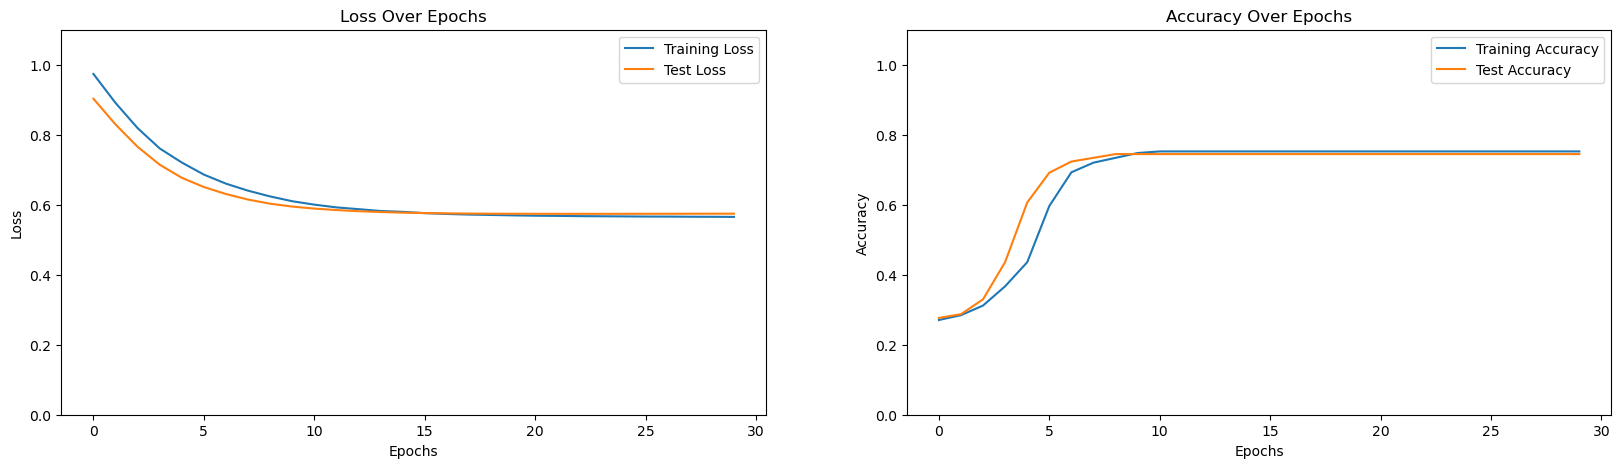

Training complex model
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 58, 10)            800440    
                                                                 
 lstm_24 (LSTM)              (None, 8)                 608       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 801,057
Trainable params: 801,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 25s 4s/step - loss: 0.7127 - accuracy: 0.2890 - val_loss: 0.6936 - val_accuracy: 0.4468
Epoch 2/30
4/4 [==============================] - 4s 847ms/step - loss: 0.7018 - accuracy: 0.3486 - val_loss: 0.6849 - val_accuracy: 0.6064
Epoch 3/30

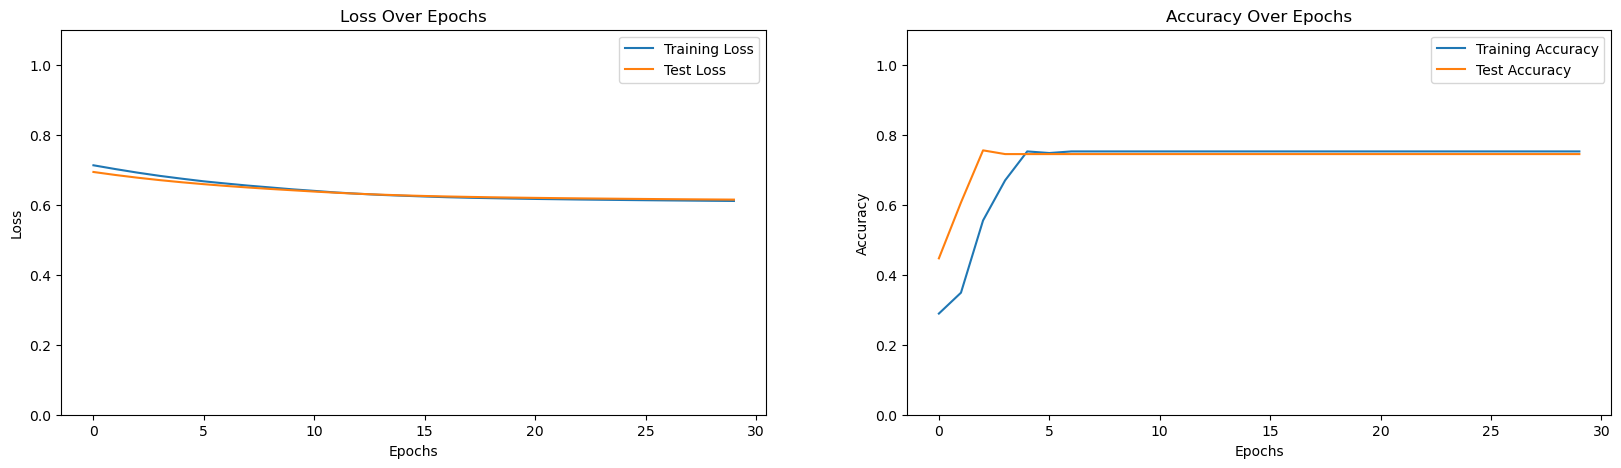

In [63]:
models = ['basic', 'complex']
for model in models:
    print(f"Training {model} model")
    history = create_and_fit_model(model_type=model)
    plot_history(history)